In [ ]:
# TODO:
# 1. matching if not all keypoints (added flag to the kps (the third dim))

In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
#from google.colab.patches import cv2_imshow
import math

In [ ]:
# Steps for running:
# 1. Download PoseNet model from https://www.tensorflow.org/lite/models/pose_estimation/overview
# 2. Choose your template and target image to process
# 3. Specify paths

In [34]:
model_path = "models/posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
template_path = "data/tennis.png"
target_path = "data/target_2.png"

In [35]:
# Load TFLite model and allocate tensors (memory usage method reducing latency)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [36]:
# Get input and output tensors information from the model file
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

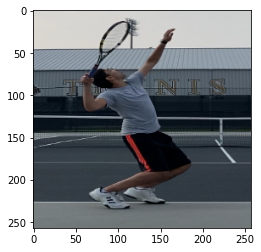

In [37]:
template_image_src = cv.imread(template_path)
# src_tepml_width, src_templ_height, _ = template_image_src.shape 
template_image = cv.resize(template_image_src, (width, height))
plt.imshow(cv.cvtColor(template_image, cv.COLOR_BGR2RGB))
plt.show()

In [38]:
# can be used later to draw keypoints on the source image (before resizing)
# templ_ratio_width = src_tepml_width/width
# templ_ratio_height = src_templ_height/height

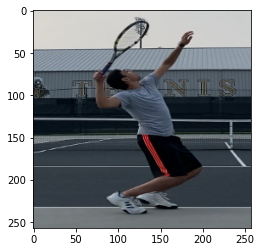

In [39]:
target_image_src = cv.imread(target_path)
# src_tar_width, src_tar_height, _ = target_image_src.shape 
target_image = cv.resize(target_image_src, (width, height))
plt.imshow(cv.cvtColor(target_image, cv.COLOR_BGR2RGB))
plt.show()

In [40]:
# tar_ratio_width = src_tar_width/width
# tar_ratio_height = src_tar_height/height

In [41]:
# add a new dimension to match model's input
template_input = np.expand_dims(template_image.copy(), axis=0)
target_input = np.expand_dims(target_image.copy(), axis=0)
print(target_input.shape)

(1, 257, 257, 3)


In [42]:
# check the type of the input tensor
floating_model = input_details[0]['dtype'] == np.float32

In [43]:
# Floating point models offer the best accuracy, at the expense of model size 
# and performance. GPU acceleration requires the use of floating point models.

# Brings input values to range from 0 to 1

In [44]:
if floating_model:
  template_input = (np.float32(template_input) - 127.5) / 127.5
  target_input = (np.float32(target_input) - 127.5) / 127.5

In [45]:
# Process template image
# Sets the value of the input tensor
interpreter.set_tensor(input_details[0]['index'], template_input)
# Runs the computation
interpreter.invoke()
# Extract output data from the interpreter
template_output_data = interpreter.get_tensor(output_details[0]['index'])
template_offset_data = interpreter.get_tensor(output_details[1]['index'])
# Getting rid of the extra dimension
template_heatmaps = np.squeeze(template_output_data)
template_offsets = np.squeeze(template_offset_data)
print("template_heatmaps' shape:", template_heatmaps.shape)
print("template_offsets' shape:", template_offsets.shape)

template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)


In [46]:
# Process target image. Same commands
interpreter.set_tensor(input_details[0]['index'], target_input)
interpreter.invoke()
target_output_data = interpreter.get_tensor(output_details[0]['index'])
target_offset_data = interpreter.get_tensor(output_details[1]['index'])
target_heatmaps = np.squeeze(target_output_data)
target_offsets = np.squeeze(target_offset_data)

In [47]:
# The output consist of 2 parts:
# - heatmaps (9,9,17) - corresponds to the probability of appearance of 
# each keypoint in the particular part of the image (9,9)(without applying sigmoid 
# function). Is used to locate the approximate position of the joint
# - offset vectors (9,9,34) is called offset vectors. Is used for more exact
#  calculation of the keypoint's position. First 17 of the third dimension correspond
# to the x coordinates and the second 17 of them correspond to the y coordinates

In [48]:
def parse_output(heatmap_data,offset_data, threshold):

  '''
  Input:
    heatmap_data - hetmaps for an image. Three dimension array
    offset_data - offset vectors for an image. Three dimension array
    threshold - probability threshold for the keypoints. Scalar value
  Output:
    array with coordinates of the keypoints and flags for those that have
    low probability
  '''

  joint_num = heatmap_data.shape[-1]
  pose_kps = np.zeros((joint_num,3), np.uint32)

  for i in range(heatmap_data.shape[-1]):

      joint_heatmap = heatmap_data[...,i]
      max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
      remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
      pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
      pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
      max_prob = np.max(joint_heatmap)

      if max_prob > threshold:
        if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
          pose_kps[i,2] = 1

  return pose_kps

In [49]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
      if kps[i,2]:
        if isinstance(ratio, tuple):
          cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
          continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),-1)
    return show_img

In [52]:
template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
template_show = np.array(template_show*255,np.uint8)
template_kps = parse_output(template_heatmaps,template_offsets,0.3)
print(template_kps.shape)


(17, 3)


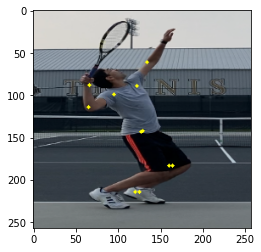

In [53]:
plt.imshow(cv.cvtColor(draw_kps(template_show.copy(),template_kps), cv.COLOR_BGR2RGB))
plt.show()

In [60]:
target_show = np.squeeze((target_input.copy()*127.5+127.5)/255.0)
target_show = np.array(target_show*255,np.uint8)
target_kps = parse_output(target_heatmaps,target_offsets,0.3)


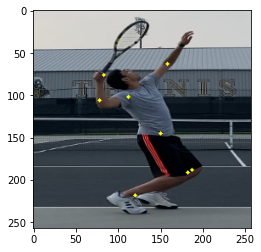

In [61]:
plt.imshow(cv.cvtColor(draw_kps(target_show.copy(),target_kps), cv.COLOR_BGR2RGB))
plt.show()

### Matching by angles and proportions

#### Set template values

In [ ]:
# Matching keypoints indices in the output of PoseNet
# 0. Left shoulder to right shoulder (5-6)
# 1. Left shoulder to left elbow (5-7)
# 2. Right shoulder to right elbow (6-8)
# 3. Left elbow to left wrist (7-9)
# 4. Right elbow to right wrist (8-10)
# 5. Left hip to right hip (11-12)
# 6. Left shoulder to left hip (5-11)
# 7. Right shoulder to right hip (6-12)
# 8. Left hip to left knee (11-13)
# 9. Right hip to right knee (12-14)
# 10. Left knee to left ankle (13-15)
# 11.  Right knee to right ankle (14-16)

In [62]:
parts_to_compare = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]

In [63]:
def angle_length(p1, p2):

  '''
  Input:
    p1 - coordinates of point 1. List
    p2 - coordinates of point 2. List
  Output:
    Tuple containing the angle value between the line formed by two input points 
    and the x-axis as the first element and the length of this line as the second
    element
  '''

  angle = math.atan2(- int(p2[0]) + int(p1[0]), int(p2[1]) - int(p1[1])) * 180.0 / np.pi
  length = math.hypot(int(p2[1]) - int(p1[1]), - int(p2[0]) + int(p1[0]))
  
  return round(angle), round(length)

In [64]:
template_values = []
for part in parts_to_compare:
  template_values.append(angle_length(template_kps[part[0]][:2], template_kps[part[1]][:2]))
template_values

[(20, 29),
 (-153, 34),
 (67, 30),
 (88, 26),
 (-159, 63),
 (-153, 2),
 (-52, 55),
 (-85, 54),
 (-50, 54),
 (-50, 52),
 (-142, 50),
 (-142, 51)]

In [65]:
target_values = []
for part in parts_to_compare:
  target_values.append(angle_length(target_kps[part[0]][:2], target_kps[part[1]][:2]))
target_values

[(21, 22),
 (-173, 34),
 (51, 40),
 (81, 30),
 (55, 28),
 (0, 12),
 (-59, 50),
 (-72, 54),
 (-41, 65),
 (-55, 56),
 (-156, 73),
 (-157, 70)]

In [ ]:
# with open('template.pkl', 'wb') as f:
#   pickle.dump(template, f)

In [ ]:
# with open('template.pkl', 'rb') as f:
#   template = pickle.load(f)

#### Matching

In [67]:
def matching(template_kp, target_kp, angle_deviation=30, size_deviation=1):

  '''Input:
      1. template_kp - list of tuples (for the template image) containng angles 
      between particular body parts and x-axis as first elements and its sizes 
      (distances between corresponding points as second elements)
      2. target_kp - same for the target image
      3. angle_deviation - acceptable angle difference between corresponding 
      body parts in the images
      4. size_deviation - acceptable proportions difference between the images
    Output:
      List of body parts which are deviated
  '''

  devs = []

  # set an anchor size for proportions calculations - distance between shoulders
  templ_anchor = template_kp[0][1]
  targ_anchor = target_kp[0][1]

  # for each body part that we calculated angle and size for
  for i in range(len(template_kp)):

    angles = (template_kp[i][0], target_kp[i][0])
    diff_angle = max(angles) - min(angles)

    templ_size = (template_kp[i][1],templ_anchor)
    templ_size = abs(min(templ_size) / max(templ_size))

    tar_size = (target_kp[i][1], targ_anchor)
    tar_size = abs(min(tar_size) / max(tar_size))

    if diff_angle > angle_deviation:
      devs.append(i)
      print("{0} has different angle".format(i))

    elif max(tar_size,templ_size) - min(tar_size,templ_size) > size_deviation:
      devs.append(i)
      print("{0} has different size".format(i))

  return devs

In [75]:
deviations = matching(template_values, target_values,angle_deviation=20)
deviations

4 has different angle
5 has different angle


[4, 5]

#### Draw deviations

In [76]:
def draw_deviations(img, keypoints, pairs, deviations):

  for i, pair in enumerate(pairs):

    if i in deviations:
      color = (0,0,255)
    else:
      color = (0,255,0)
      
    cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

In [77]:
draw_deviations(target_show, target_kps, parts_to_compare, deviations)

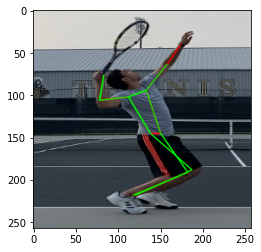

In [78]:
plt.imshow(cv.cvtColor(target_show, cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
# cv.imwrite('devs.jpg', target_show)

True

### Matching by finding the target pose in the image

#### Set a target pattern

In [ ]:
# Get a zero matrix with the shape of the template image
template_pose = np.zeros_like(template_show)

In [ ]:
# connect some of the points 
def join_point(img, kps):

  body_parts = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),
                      (6,12),(11,13),(12,14),(13,15),(14,16)]

  for part in body_parts:
    cv.line(img, (kps[part[0]][1], kps[part[0]][0]), (kps[part[1]][1], kps[part[1]][0]), 
            color=(255,255,255), lineType=cv.LINE_AA, thickness=3)


In [ ]:
# draw a skeleton of the template pose to the empty image
join_point(template_pose, template_kps[:, :2])

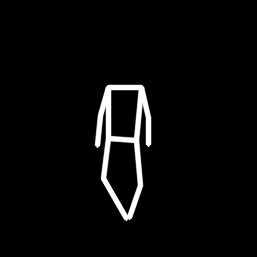

In [ ]:
cv2_imshow(template_pose)

In [ ]:
# set the new dimensions of the image to reduce the size
buffer = 5 # size of the area around the pose
top_left_y = min(template_kps[5:, 0]) - buffer
top_left_x = min(template_kps[5:, 1]) - buffer
buttom_right_y = max(template_kps[5:, 0]) + buffer
buttom_right_x = max(template_kps[5:, 1]) + buffer

In [ ]:
# crop the template pose with new dimensions
template_pose = template_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

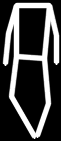

In [ ]:
cv2_imshow(template_pose)

In [ ]:
# save the template pattern
# cv.imwrite('template_pose.jpg', template_pose)

#### Find the pattern in the new image

In [ ]:
# Get a zero matrix with the shape of the target image
target_pose = np.zeros_like(target_show)

In [ ]:
# draw a skeleton of the target pose to the empty image
join_point(target_pose, target_kps[:, :2])

In [ ]:
# set the new dimensions of the image to reduce the size
buffer = 5 # size of the area around the pose
top_left_y = min(target_kps[5:, 0]) - buffer
top_left_x = min(target_kps[5:, 1]) - buffer
buttom_right_y = max(target_kps[5:, 0]) + buffer
buttom_right_x = max(target_kps[5:, 1]) + buffer

In [ ]:
target_pose = target_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

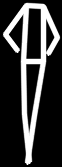

In [ ]:
cv2_imshow(target_pose)

In [ ]:
template_pose = cv.cvtColor(template_pose, cv.COLOR_BGR2GRAY)
target_pose = cv.cvtColor(target_pose, cv.COLOR_BGR2GRAY)

In [ ]:
# the greater the threshold the more exact the pose has to match
threshold = 0.1

w, h = target_pose.shape[::-1]
res = cv.matchTemplate(target_pose,template_pose, cv.TM_CCOEFF_NORMED)
score = res.max()

print("score:", score)

if score >= threshold:
  print("Match")
else:
  print("Don't match")

score: 0.16486926
Match


### Draw grid

In [ ]:
def draw_grid(img, grid_size=9, heatmap=None, part=1):

    color = (0,255,255)

    small_size = min(img.shape[0], img.shape[1])
    cell_size = small_size // grid_size
    res = int(small_size % grid_size)

    x = res // 2
    y = res // 2

    while x < img.shape[1]:
      cv.line(img, (x, 0), (x, img.shape[0]), color=color, lineType=cv.LINE_AA, thickness=1)
      x += cell_size

    while y < img.shape[0]:
      cv.line(img, (0, y), (img.shape[1], y), color=color, lineType=cv.LINE_AA, thickness=1)
      y += cell_size

    center_x = res//2
    center_y = res//2 + cell_size//2

    cv.putText(image,str(round(heatmap[0,0,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)

    for row_idx, row in enumerate(heatmap[...,part]):

      for col_idx, column in enumerate(row):
        cv.putText(image,str(round(heatmap[col_idx,row_idx,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)
        center_y += cell_size
        
      center_x += cell_size
      center_y = res//2 + cell_size//2

In [ ]:
# image = cv.imread('image.jpg')
# image = cv.resize(image, (257, 257)) 

In [ ]:
# draw_grid(image, 9, template_heatmaps)

In [ ]:
# cv2_imshow(image)

In [ ]:
# cv.imwrite('image.jpg', image)